# deep learning assignment

# Part 1: ...........................Preparing SVG code....................................

## step 1: SVG extraction and tokenization
In this substep we will focus on the following steps:
- load data
- extract data
- adding startseq and endseq in our svg examples
- Use: startseq at the beginning of SVG code
- Use: endseq at the end of the SVG code

In [1]:
my_path = 'C:/Users/voice/Downloads/train/train/'

In [2]:
def SVG_EXTRACTION(my_path, svg):
    target_texts = []
    target_characters = set()
    for num in range(48000):
        num = str(num)
        file = open(my_path+'svg/'+num+".svg", 'r')
        for index, line in enumerate(file):

            if index == 1:
                target_text = 'startseq '+line+' endseq'
                target_texts.append(target_text)
                for char in target_text.split(" "):
                    if char not in target_characters:
                        target_characters.add(char)
    
    #Step 1: detect shape with the largest dimension       
    largest_shape = 0
    for x in target_texts:
        x = x.split(" ")
        all_shapes = len(x)
        if all_shapes > largest_shape:
            largest_shape = all_shapes
            
    target_characters = sorted(list(target_characters))
    num_decoder_tokens = len(target_characters)
    max_decoder_seq_length = largest_shape
    
    return target_texts, target_characters, num_decoder_tokens, max_decoder_seq_length

SVG = SVG_EXTRACTION(my_path,'.svg')


In [3]:
target_texts, target_characters, num_decoder_tokens, max_decoder_seq_length = SVG

# Checkpoint

In [4]:
print('SVG code training examples     :', len(target_texts))
print('Number of unique output tokens :', num_decoder_tokens)
print('Max sequence length for outputs:', max_decoder_seq_length)

SVG code training examples     : 48000
Number of unique output tokens : 55
Max sequence length for outputs: 65


# step 2

- create decoder input data
- create decoder target data

In [5]:
import numpy as np
target_token_index = dict([(word, i) for i, word in enumerate(target_characters)])
decoder_input_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

# step 3

- Set decoder_target_data one timestemp ahead of decoder_input_data

In [6]:
target_token_index = dict([(word, i) for i, word in enumerate(target_characters)])

decoder_input_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')
decoder_target_data = np.zeros((len(target_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

for i,target_text in enumerate(target_texts):
    target_text = target_text.split(" ")
    #print(i,target_text)
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index['startseq']] = 1.
    decoder_target_data[i, t:, target_token_index['startseq']] = 1.

# Checkpoint

In [7]:
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(48000, 65, 55)
(48000, 65, 55)


# Part 2: ..........................Preparing PNG images......................................

## step 1: PNG extraction and feature extraction
In this substep we want to focus on the following steps:
- load data
- extract data in an array


In [8]:
import numpy
from PIL import Image
def PNG_EXTRACTION(file_name, svg):
    png_extract = []
    for num in range(48000):
        file = Image.open(file_name+str(num)+svg)
        file = numpy.asarray(file)
        png_extract.append(file)
    
    png_extract = numpy.array(png_extract)
    return png_extract
    file.close()
PNG = PNG_EXTRACTION(my_path+'png/','.png')

# Checkpoint

In [9]:
print(PNG.shape)

(48000, 64, 64, 4)


# Part 3: ..................................data overview.................................................

In [10]:
encoder_input_data = PNG

# Checkpoint
#### data overview
- encoder_input_data
- decoder_input_data
- decoder_target_data

In [11]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(48000, 64, 64, 4)
(48000, 65, 55)
(48000, 65, 55)


# Part 4: .....................................Build Model.................................................

- CNN: Learns features from PNG images
- LSTM: Predicts the svg code sequence

In [12]:
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Input, RepeatVector, Reshape, LSTM, Dropout, Dense, Conv2D, TimeDistributed, Activation,RepeatVector, MaxPooling2D, Flatten

# Parameters for the model.
hidden_size = 128

# Process image to sequence
image_input = Input(shape=(64,64,4,))
conv_layer1 = Conv2D(16, (3, 3), activation='relu', strides=(1,1), padding='same')(image_input)
pool1 = MaxPooling2D(pool_size=(2,2),strides = None, padding = 'valid')(conv_layer1)
conv_layer2 = Conv2D(16, (3, 3), activation='relu', strides=(2,2), padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2,2),strides = None, padding = 'valid')(conv_layer2)

flatten_layer = Flatten()(pool2)
dropout_layer = Dropout(0.5)(flatten_layer)
encoder_input = Dense(256, activation = 'relu')(dropout_layer)

encoder_inputs = RepeatVector(55)(encoder_input)
encoder_rnn_layer = LSTM(hidden_size, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_rnn_layer(encoder_inputs)
encoder_state = [state_h, state_c]

decoder_inputs = Input(shape=(None, 55))

decoder_rnn_layer = LSTM(hidden_size, return_sequences=True, return_state=True)
decoder_outputs,_ ,_ = decoder_rnn_layer(decoder_inputs, initial_state=encoder_state)
decoder_dense = Dense(55, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_inputs` & `decoder_inputs` into `decoder_outputs`
model = Model([image_input, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy',
                  optimizer= Adam(lr=0.0001),
                  metrics=['accuracy'])

model.summary()

Using TensorFlow backend.
C:\Users\voice\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\voice\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\voice\Anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\voice\Anaconda3\lib\site-packages\tensorboard\comp






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   592         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 16)   2320        max_

# fit model

In [13]:
cnn_lstm = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size= 64,
          epochs= 100,
          validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 38400 samples, validate on 9600 samples
Epoch 1/100





38400/38400 [==============================] - 237s 6ms/step - loss: 1.8474 - acc: 0.5981 - val_loss: 1.3076 - val_acc: 0.6792
Epoch 2/100
38400/38400 [==============================] - 247s 6ms/step - loss: 1.1730 - acc: 0.7115 - val_loss: 1.0356 - val_acc: 0.7432
Epoch 3/100
38400/38400 [==============================] - 247s 6ms/step - loss: 0.8122 - acc: 0.7831 - val_loss: 0.6244 - val_acc: 0.8032
Epoch 4/100
38400/38400 [==============================] - 249s 6ms/step - loss: 0.5490 - acc: 0.8043 - val_loss: 0.4917 - val_acc: 0.8062
Epoch 5/100
38400/38400 [==============================] - 249s 6ms/step - loss: 0.4621 - acc: 0.8095 - val_loss: 0.4375 - val_acc: 0.8110
Epoch 6/100
38400/38400 [==============================] - 247s 6ms/step - loss: 0.4231 - acc: 0.8156 - val_loss: 0.4115 - val_acc: 0.8161
Epoch 7/100
384

38400/38400 [==============================] - 238s 6ms/step - loss: 0.2996 - acc: 0.8778 - val_loss: 0.2944 - val_acc: 0.8804
Epoch 46/100
38400/38400 [==============================] - 222s 6ms/step - loss: 0.2986 - acc: 0.8785 - val_loss: 0.2925 - val_acc: 0.8811
Epoch 47/100
38400/38400 [==============================] - 229s 6ms/step - loss: 0.2974 - acc: 0.8790 - val_loss: 0.2929 - val_acc: 0.8811
Epoch 48/100
38400/38400 [==============================] - 229s 6ms/step - loss: 0.2963 - acc: 0.8797 - val_loss: 0.2902 - val_acc: 0.8827
Epoch 49/100
38400/38400 [==============================] - 227s 6ms/step - loss: 0.2954 - acc: 0.8803 - val_loss: 0.2895 - val_acc: 0.8830
Epoch 50/100
38400/38400 [==============================] - 227s 6ms/step - loss: 0.2945 - acc: 0.8807 - val_loss: 0.2884 - val_acc: 0.8837
Epoch 51/100
38400/38400 [==============================] - 228s 6ms/step - loss: 0.2935 - acc: 0.8812 - val_loss: 0.2884 - val_acc: 0.8834
Epoch 52/100
38400/38400 [=======

# plot loss and accuracy

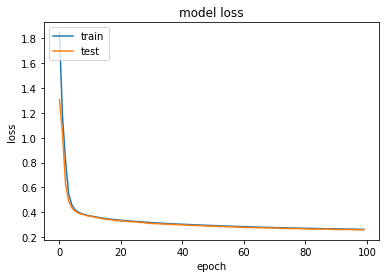

In [14]:
import matplotlib.pyplot as plt
plt.plot(cnn_lstm.history['loss'])
plt.plot(cnn_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

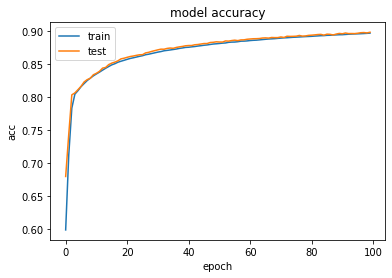

In [15]:
plt.plot(cnn_lstm.history['acc'])
plt.plot(cnn_lstm.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# decoder model

In [16]:
encoder_model = Model(image_input, encoder_state)

decoder_state_input_h = Input(shape=(128,))
decoder_state_input_c = Input(shape=(128,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_rnn_layer(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

## Reverse-lookup token index in order to decode sequences back to something readable.

In [17]:
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

# Part 5: ................................Decode sequence...........................................

In [18]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['startseq']] = 1.

    # Sampling loop for a batch of sequences
    stop_condition = False
    #decoded_sentence = ''
    decoded_sentence = []
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        #decoded_sentence += sampled_char
        decoded_sentence.append(sampled_char)
        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == 'endseq' or sampled_char == 'startseq' or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [19]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    print('-')
    print('Image input shape:', input_seq.shape)
    #print('Input sequence:', training_features[seq_index])
    print('Decoded svg code:', decoded_sentence)

-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="teal"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="purple"', 'rx="32.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="16.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
Image input sha

-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="cyan"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="fuchsia"', 'rx="8.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="teal"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/><rect', 'fill="navy"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/></svg>', 'endseq']
-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height

-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="silver"', 'height="32.0"', 'width="32.0"', 'x="32.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="8.0"', 'ry="32.0"', '/><rect', 'fill="purple"', 'height="32.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="teal"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="purple"', 'rx="8.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
Image in

-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="lime"', 'height="16.0"', 'width="32.0"', 'x="8.0"', 'y="8.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="teal"', 'rx="8.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="navy"', 'rx="16.0"', 'ry="16.0"', '/><rect', 'fill="cyan"', 'height="8.0"', 'width="16.0"', 'x="8.0"', 'y="56.0"', '/></svg>', 'endseq']
-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="6

-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="silver"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="fuchsia"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="cyan"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
Image input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="blue"', 'rx="16.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="blue"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="32.

# Part 6 ...................................Test data preparation..........................................


# step 1: load test data

In [20]:
my_path_2 = 'C:/Users/voice/Downloads/test/test/'

In [21]:
import numpy
from PIL import Image

def PNG_EXTRACTION(file_name, svg):
    png_extract = []
    for num in range(48000,50000):
        file = Image.open(file_name+str(num)+svg)
        file = numpy.asarray(file)
        png_extract.append(file)
    
    png_extract = numpy.array(png_extract)
    return png_extract
    file.close()
PNG_test = PNG_EXTRACTION(my_path_2+'png/','.png')

# Checkpoint

In [22]:
PNG_test.shape

(2000, 64, 64, 4)

## save PNG as encoder_input_test_data

In [23]:
encoder_input_test_data = PNG_test

## decode sequence

In [24]:
decoded_predictions = []
for seq_index in range(2000):

    input_seq = encoder_input_test_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    decoded_predictions.append(decoded_sentence)
    print('-')
    print('input shape:', input_seq.shape)
    #print('Input sequence:', training_features[seq_index])
    print('Decoded svg code:', decoded_sentence)

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="silver"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="cyan"', 'rx="32.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="teal"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="8.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.

Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="navy"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="blue"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="maroon"', 'rx="8.0"', 'ry="8.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="16.0"', 'ry="8.0"', '/><rect', 'fill="purple"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="32.0"', 'width="8.0"', 'x="8.0"', 'y="56.0"

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="blue"', 'height="8.0"', 'width="16.0"', 'x="8.0"', 'y="32.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="gray"', 'rx="32.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="fuchsia"', 'height="8.0"', 'width="32.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="navy"', 'rx="32.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="

input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="teal"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="silver"', 'rx="16.0"', 'ry="8.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="teal"', 'rx="16.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="teal"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="32.0"', 'widt

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="8.0"', 'ry="32.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="teal"', 'height="32.0"', 'width="32.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.

input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="16.0"', 'ry="8.0"', '/><rect', 'fill="aqua"', 'height="16.0"', 'width="16.0"', 'x="32.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="aqua"', 'height="16.0"', 'width="8.0"', 'x="32.0"', 'y="32.0"', '/><rect', 'fill="olive"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="56.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="teal"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="olive"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="56.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="8.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="32.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="green"', 'height="8.0"', 'width="32.0"', 'x="8.0"', 'y="56.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="32.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="gray"', 'rx="32.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="magenta"', 'height="8.0"', 'width="32.0"', 'x="8.0"', 'y="56.0"', '/><rect', 'fill="magenta"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="8.0"', '/><rect', 'fill="navy"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="56.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fi

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="silver"', 'height="32.0"', 'width="32.0"', 'x="56.0"', 'y="56.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="red"', 'rx="32.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="red"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="navy"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="olive"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="teal"', 'height="32.0"', 'width="32.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="teal"', 'rx="32.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version=

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="teal"', 'height="32.0"', 'width="16.0"', 'x="32.0"', 'y="8.0"', '/><rect', 'fill="cyan"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="56.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="gray"', 'rx="16.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="green"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="cyan"', 'height="16.0"', 'width="8.0"', 'x="8.0"', 'y="32.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="gray"', 'height="8.0"', 'width="32.0"', 'x="8.0"', 'y="56.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="gray"', 'rx="32.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="silver"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="8.0"', '/><rect', 'fill="black"', 'height="32.0"', 'width="32.0"', 'x="32.0"', 'y="56.0"', '/><rect', 'fill="black"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="teal"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="teal"', 'rx="8.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="aqua"', 'height="32.0"', 'width="32.0"', 'x="32.0"', 'y="8.0"', '/><rect', 'fill="cyan"', 'height="16.0"', 'width="8.0"', 'x="32.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1

Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="navy"', 'rx="16.0"', 'ry="8.0"', '/><rect', 'fill="fuchsia"', 'height="32.0"', 'width="8.0"', 'x="8.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="olive"', 'rx="16.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="navy"', 'rx="16.0"', 'ry="8.0"', '/><rect', 'fill="silver"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y=

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="8.0"', 'ry="32.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="navy"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="16.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="green"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="red"', 'rx="32.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="silver"', 'height="16.0"', 'width="32.0"', 'x="8.0"', 'y="56.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="olive"', 'rx="8.0"', 'ry="32.0"', '/><rect', 'fill="blue"', 'height="16.0"', 'width="8.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64,

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="yellow"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="blue"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="teal"', 'rx="16.0"', 'ry="16.0"', '/><rect', 'fill="gray"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="maroon"', 'rx="16.0"', 'ry="8.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fil

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="blue"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="aqua"', 'height="16.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="maroon"', 'rx="8.0"', 'ry="8.0"', '/><rect', 'fill="navy"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="olive"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="red"', 'height="32.0"', 'widt

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="navy"', 'height="32.0"', 'width="16.0"', 'x="32.0"', 'y="8.0"', '/><rect', 'fill="white"', 'height="8.0"', 'width="16.0"', 'x="8.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="blue"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="red"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="aqua"', 'rx="16.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 6

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="white"', 'height="16.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="green"', 'height="16.0"', 'width="16.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="cyan"', 'height="16.0"', 'width="8.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="cyan"', 'height="16.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/><rect', 'fill="lime"', 'height="16.0"', 'width="8.0"', 'x="8.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="fuchsia"', 'rx="32.0"', 'ry="8.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="aqua"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="red"', 'height="32.0"', 'width="8.0"', 'x="8.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="green"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="blue"', 'rx="16.0"', 'ry="8.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="aqua"', 'height="16.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/><rect', 'fill="olive"', 'height="16.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="cyan"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="teal"', 'height="32.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="cyan"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/><rect', 'fill="cyan"', 'height="32.0"', '

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="red"', 'height="16.0"', 'width="16.0"', 'x="56.0"', 'y="8.0"', '/><rect', 'fill="maroon"', 'height="16.0"', 'width="32.0"', 'x="32.0"', 'y="32.0"', '/><rect', 'fill="navy"', 'height="16.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="red"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="8.0"', 'x="8.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="fuchsia"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="teal"', 'rx="16.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="green"', 'height="32.0"', 'width="8.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="8.0"', 'x="8.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version=

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="cyan"', 'rx="16.0"', 'ry="16.0"', '/><rect', 'fill="white"', 'height="32.0"', 'width="8.0"', 'x="32.0"', 'y="32.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="16.0"', 'ry="8.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="c

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="white"', 'height="8.0"', 'width="8.0"', 'x="56.0"', 'y="56.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="8.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="aqua"', 'height="32.0"', 'width="32.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="navy"', 'height="16.0"', 'width="32.0"', 'x="32.0"', 'y="32.0"', '/><rect', 'fill="navy"', 'height="16.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64,

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="navy"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="cyan"', 'height="8.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="lime"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="olive"', 'rx="32.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="cyan"', 'rx="8.0"', 'ry="16.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="cyan"', 'rx="32.0"', 'ry="16.0"', '/><rect', 'fill="white"', 'height="8.0"', 'width="32.0"', 'x="56.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="olive"', 'rx="32.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="cyan"', 'rx="16.0"', 'ry="16.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="gray"', 'rx="16.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="white"', 'height="8.0"', 'width="16.0"', 'x="8.0"', 'y="56.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="32.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="navy"', 'height="8.0"', 'width="16.0"', 'x="32.0"', 'y="32.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="gray"', 'rx="16.0"', 'ry="8.0"', '/><rect', 'fill="gray"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="green"', 'rx="32.0"', 'ry="8.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="aqua"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="n

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="maroon"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="gray"', 'rx="16.0"', 'ry="16.0"', '/><rect', 'fill="purple"', 'height="16.0"', 'width="16.0"', 'x="32.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="cyan"', 'rx="8.0"', 'ry="8.0"', '/><rect', 'fill="fuchsia"', 'height="16.0"', 'width="8.0"', 'x="32.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="fuchsia"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="red"', 'rx="32.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="32.0"', '/><rect', 'fill="silver"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'versi

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="fuchsia"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="olive"', 'rx="8.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="blue"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="maroon"', 'rx="32.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="olive"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="olive"', 'height="16.0"', 'width="32.0"', 'x="8.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="maroon"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="navy"', 'rx="32.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="olive"', 'rx="16.0"', 'ry="8.0"', '/><rect', 'fill="gray"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="aqua"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="green"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="red"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="fuchsia"', 'height="16.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="8.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="red"', 'height="16.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="8.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64,

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="teal"', 'rx="32.0"', 'ry="8.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="silver"', 'rx="16.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="fuchsia"', 'rx="32.0"', 'ry="8.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="navy"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"'

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="navy"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="maroon"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="green"', 'rx="16.0"', 'ry="8.0"', '/><rect', 'fill="navy"', 'height="8.0"', 'width="16.0"', 'x="32.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="teal"', 'height="32.0"', 'width="32.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="blue"', 'height="16.0"', 'width="32.0"', 'x="32.0"', 'y="8.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="gray"', 'rx="16.0"', 'ry="16.0"', '/><rect', 'fill="lime"', 'height="16.0"', 'width="16.0"', 'x="56.0"', 'y="32.0"', '/><rect', 'fill="navy"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="navy"', 'rx="32.0"', 'ry="16.0"', '/><rect', 'fill="fuchsia"', 'height="16.0"'

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="teal"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="fuchsia"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="teal"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="blue"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fi

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="fuchsia"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="blue"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="red"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="magenta"', 'rx="8.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="na

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="olive"', 'rx="8.0"', 'ry="8.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="navy"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="blue"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="red"', 'rx="32.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Deco

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="teal"', 'rx="32.0"', 'ry="16.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="32.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="maroon"', 'rx="8.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="navy"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="8.0"'

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="lime"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="red"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="gray"', 'height="16.0"', 'width="32.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="blue"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="green"', 'rx="16.0"', 'ry="8.0"', '/><rect', 'fill="purple"', 'height="16.0"', 'widt

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="silver"', 'height="16.0"', 'width="32.0"', 'x="32.0"', 'y="56.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="teal"', 'rx="8.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="32.0"', 'width="32.0"', 'x="32.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="green"', 'rx="16.0"', 'ry="16.0"', '/><rect', 'fill="purple"', 'height="32.0"', 'width="16.0"', 'x="32.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="blue"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="maroon"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="teal"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="56.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="olive"', 'rx="32.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="blue"', 'rx="16.0"', 'ry="16.0"', '/><rect', 'fill="red"', 'height="32.0"', 'wi

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="cyan"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="fuchsia"', 'height="8.0"', 'width="8.0"', 'x="32.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="32.0"', 'width="16.0"', 'x="32.0"', 'y="32.0"', '/><rect', 'fill="navy"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="32.0"', '/><rect', 'fill="maroon"', 'height="32.0"', 'width="32.0"', 'x="8.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="blue"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="blue"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="16.0"', 'width="8.0"', 'x="8.0"', 'y="56.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="olive"', 'rx="32.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 6

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="lime"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="magenta"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="purple"', 'rx="16.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="maroon"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="silver"', 'height="32.0"', 'width="32.0"', 'x="8.0"', 'y="8.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="gray"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="32.0"', 'y="32.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 6

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="blue"', 'rx="16.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="fuchsia"', 'rx="32.0"', 'ry="8.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="navy"', 'rx="16.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="teal"', 'rx="32.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64,

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="navy"', 'rx="8.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="32.0"', 'ry="8.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="gray"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="gray"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="silver"', 'height="32.0"', 'width="32.0"', 'x="8.0"', 'y="8.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="gr

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="16.0"', 'ry="8.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="blue"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="cyan"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="silver"', 'rx="16.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64,

Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="silver"', 'height="16.0"', 'width="32.0"', 'x="8.0"', 'y="56.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="green"', 'rx="8.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="32.0"', 'width="16.0"', 'x="32.0"', 'y="32.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="fuchsia"', 'height="32.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: 

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="gray"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="purple"', 'height="8.0"', 'width="16.0"', 'x="8.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="aqua"', 'height="32.0"', 'width="32.0"', 'x="8.0"', 'y="32.0"', '/><rect', 'fill="navy"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/><rect', 'fill="navy"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64,

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="yellow"', 'height="16.0"', 'width="32.0"', 'x="8.0"', 'y="56.0"', '/><rect', 'fill="green"', 'height="16.0"', 'width="16.0"', 'x="32.0"', 'y="8.0"', '/><rect', 'fill="green"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="teal"', 'rx="16.0"', 'ry="8.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="silver"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="blue"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xli

Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="teal"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="maroon"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="cyan"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="teal"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="green"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="teal"', 'rx="8.0"', 'ry="8.0"'

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="lime"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="32.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="maroon"', 'height="32.0"', 'width="8.0"', 'x="8.0"', 'y="56.0"', '/><rect', 'fill="maroon"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'vers

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="8.0"', 'y="56.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="navy"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="purple"', 'height="8.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="silver"', 'height="32.0"', 'width="16.0"', 'x="32.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fi

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="teal"', 'height="32.0"', 'width="16.0"', 'x="32.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="gray"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="teal"', 'height="32.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="blue"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="yellow"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="teal"', 'height="16.0"', '

input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="blue"', 'height="16.0"', 'width="16.0"', 'x="32.0"', 'y="8.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="gray"', 'rx="16.0"', 'ry="8.0"', '/><rect', 'fill="navy"', 'height="16.0"', 'width="32.0"', 'x="56.0"', 'y="32.0"', '/><rect', 'fill="navy"', 'height="8.0"', 'width="8.0"', 'x="32.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="32.0"', 'width="16.0"', 'x="32.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="purple"', 'height="32.0"', 'width="32.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="maroon"', 'rx="8.0"', 'ry="8.0"', '/><rect', 'fill="teal"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="32.0"', 'ry="16.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="8.0"', 'x="8.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="gray"', 'height="32.0"', 'width="32.0"', 'x="32.0"', 'y="56.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="32.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="fuchsia"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="green"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1

Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="cyan"', 'height="16.0"', 'width="32.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="cyan"', 'height="16.0"', 'width="8.0"', 'x="56.0"', 'y="56.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="white"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="navy"', 'height="16.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="cyan"', 'rx="8.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="fuchsia"', 'rx="16.0"', 'ry="32

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="maroon"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="navy"', 'rx="32.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="8.0"', 'width="8.0"', 'x="8.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="blue"', 'height="32.0"', 'width="16.0"', 'x="32.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="red"', 'rx="16.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="green"', 'height="8.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="gray"', 'rx="16.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="teal"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="olive"', 'rx="32.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="aqua"', 'height="32.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="8.0"', 'ry="32.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64,

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="gray"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="red"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="8.0"', 'width="32.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="gray"', 'rx="16.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 6

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="navy"', 'rx="16.0"', 'ry="16.0"', '/><rect', 'fill="cyan"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="56.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="olive"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="navy"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="red"', 'height="16.0"', 'width="8.0"', 'x="8.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="red"', 'height="8.0"', 'width="1

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="green"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="red"', 'height="32.0"', 'width="8.0"', 'x="32.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="green"', 'rx="8.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="silver"', 'height="16.0"', 'width="32.0"', 'x="8.0"', 'y="56.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="green"', 'rx="16.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 6

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="blue"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="blue"', 'rx="32.0"', 'ry="16.0"', '/><rect', 'fill="white"', 'height="8.0"', 'width="8.0"', 'x="8.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="green"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="blue"', 'height="16.0"', 'width="16.0"', 'x="32.0"', 'y="32.0"', '/><rect', 'fill="blue"', 'height="32.0"', 'width=

Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="silver"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="magenta"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="teal"', 'height="32.0"', 'width="32.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="navy"', 'rx="16.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="16.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<s

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="red"', 'height="16.0"', 'width="8.0"', 'x="32.0"', 'y="8.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="32.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="fuchsia"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="navy"', 'rx="8.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="olive"', 'rx="8.0"', 'ry="8.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="silver"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="olive"', 'height="16.0"', 'width="8.0"', 'x="8.0"', 'y="32.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="purple"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="white"', 'height="8.0"', 'width=

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="blue"', 'height="32.0"', 'width="16.0"', 'x="32.0"', 'y="56.0"', '/><rect', 'fill="blue"', 'height="16.0"', 'width="16.0"', 'x="8.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="gray"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="teal"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="maroon"', 'rx="16.0"', 'ry="8.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fi

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="teal"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="gray"', 'rx="16.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="16.0"', 'ry="16.0"', '/><rect', 'fill="gray"', 'height="8.0"', 'width="32.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="16.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="8.0"', 'ry="32.0"', '/><rect', 'fill="olive"', 'height="32.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="8.0"', 'ry="8.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="fuchsia"', 'rx="8.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="red"', 'rx="16.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="32.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="32.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="olive"', 'rx="32.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64,

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="lime"', 'rx="32.0"', 'ry="8.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="maroon"', 'rx="8.0"', 'ry="32.0"', '/><rect', 'fill="fuchsia"', 'height="8.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="navy"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="8.0"', 'width="16.0"', 'x="8.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 6

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="blue"', 'rx="16.0"', 'ry="16.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="blue"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="cyan"', 'height="16.0"', 'width="8.0"', 'x="8.0"', 'y="56.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="aqua"', 'rx="8.0"', 'ry="32.0"', '/><rect', 'fill="silver"', 'height="16.0"', 'width="16.0"', 'x="32.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill=

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="silver"', 'rx="16.0"', 'ry="16.0"', '/><rect', 'fill="fuchsia"', 'height="32.0"', 'width="16.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="teal"', 'rx="16.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="56.0"', 'fill="blue"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="maroon"', 'rx="32.0"', 'ry="16.0"', '/><rect', 'fill="teal"', 'height="32.0"'

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="32.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="green"', 'rx="16.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="olive"', 'rx="8.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1

input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="maroon"', 'rx="16.0"', 'ry="16.0"', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="navy"', 'rx="32.0"', 'ry="8.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="red"', 'rx="16.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="olive"', 'rx="8.0"', 'ry="16.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)


-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="silver"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="56.0"', '/><rect', 'fill="red"', 'height="32.0"', 'width="32.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="navy"', 'height="16.0"', 'width="32.0"', 'x="56.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="aqua"', 'height="32.0"', 'width="8.0"', 'x="8.0"', 'y="8.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="8.0"', 'x="32.0"', 'y="32.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fil

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="navy"', 'height="8.0"', 'width="16.0"', 'x="32.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="green"', 'rx="16.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="32.0"', 'ry="16.0"', '/><rect', 'fill="magenta"', 'height="32.0"', 'width="32.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="black"', 'rx="32.0"', 'ry="16.0"', '/><rect', 'fill="purple"', 'height="32.0"',

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="32.0"', 'x="8.0"', 'y="32.0"', '/><rect', 'fill="olive"', 'height="8.0"', 'width="16.0"', 'x="32.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="32.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="silver"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="cyan"', 'rx="8.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="fuchsia"', 'rx="8.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="navy"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="8.0"', 'cy="8.0"', 'fill="navy"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="green"', 'height="32.0"', 'width="8.0"', 'x="56.0"', 'y="32.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="m

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="cyan"', 'height="16.0"', 'width="8.0"', 'x="8.0"', 'y="56.0"', '/><rect', 'fill="olive"', 'height="16.0"', 'width="8.0"', 'x="32.0"', 'y="8.0"', '/><rect', 'fill="olive"', 'height="16.0"', 'width="8.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="fuchsia"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="16.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fi

Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="blue"', 'rx="8.0"', 'ry="32.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="blue"', 'rx="8.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="32.0"', 'ry="8.0"', '/><rect', 'fill="gray"', 'height="16.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy"', 'rx="16.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="green"', 'rx="8.0"', 'ry="32.0"', '/>

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="silver"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="56.0"', 'cy="8.0"', 'fill="olive"', 'rx="32.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="blue"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="red"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="56.0"', 'cy="56.0"', 'fill="teal"', 'rx="32.0"', 'ry="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="cyan"', 'rx="8.0"', 'ry="16.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="cyan"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="cyan"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="white"', 'rx="8.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'w

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="56.0"', '/><ellipse', 'cx="32.0"', 'cy="32.0"', 'fill="gray"', 'rx="32.0"', 'ry="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="red"', 'rx="32.0"', 'ry="32.0"', '/><rect', 'fill="cyan"', 'height="32.0"', 'width="32.0"', 'x="32.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="red"', 'height="32.0"', 'width="8.0"', 'x="32.0"', 'y="8.0"', '/><rect', 'fill="purple"', 'height="8.0"', 'width="8.0"', 'x="56.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="aqua"', 'height="32.0"', 'width="32.0"', 'x="32.0"', 'y="32.0"', '/><rect', 'fill="navy"', 'height="16.0"', 'width="32.0"', 'x="32.0"', 'y="8.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version=

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="cyan"', 'rx="32.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="gray"', 'rx="16.0"', 'ry="16.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="cyan"', 'rx="16.0"', 'ry="32.0"', '/><rect', 'fill="purple"', 'height="32.0"', 'width="8.0"', 'x="32.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="32.0"', 'x="32.0"', 'y="8.0"', '/><rect', 'fill="black"', 'height="8.0"', 'wi

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="green"', 'height="32.0"', 'width="16.0"', 'x="8.0"', 'y="32.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="16.0"', 'ry="8.0"', '/><rect', 'fill="red"', 'height="16.0"', 'width="16.0"', 'x="56.0"', 'y="32.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="16.0"', 'x="32.0"', 'y="32.0"', '/><ellipse', 'cx="8.0"', 'cy="56.0"', 'fill="navy"', 'rx="16.0"', 'ry="16.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 

-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><rect', 'fill="olive"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="8.0"', '/><ellipse', 'cx="32.0"', 'cy="8.0"', 'fill="gray"', 'rx="16.0"', 'ry="8.0"', '/><rect', 'fill="teal"', 'height="8.0"', 'width="16.0"', 'x="56.0"', 'y="56.0"', '/></svg>', 'endseq']
-
input shape: (1, 64, 64, 4)
Decoded svg code: ['<svg', 'baseProfile="full"', 'height="64"', 'version="1.1"', 'width="64"', 'xmlns="http://www.w3.org/2000/svg"', 'xmlns:ev="http://www.w3.org/2001/xml-events"', 'xmlns:xlink="http://www.w3.org/1999/xlink"><defs', '/><ellipse', 'cx="56.0"', 'cy="32.0"', 'fill="red"', 'rx="16.0"', 'ry="16.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="red"', 'rx="32.0"', 'ry="32.0"', '/><ellipse', 'cx="8.0"', 'cy="32.0"', 'fill="navy

# part 7: ......................................clean output data..........................................
- remove endseq
- retrieve and append first line for all svg codes
- join all words in lists
- transform list into string

In [25]:
first_line = '<?xml version="1.0" encoding="utf-8" ?>'
clean_predictions = []
decoded_predictions[0]
for index, i in enumerate(decoded_predictions):
    #remove 'endseq'
    i = i[:-1]
    i = (" ").join(i)
    clean_predictions.append(i)

## create 2000 empty files
- create an empty file in your directory
- name it result

In [26]:
save_path = 'C:/Users/voice/Downloads/test/result/'

In [27]:
for i in range(48000,50000):
    i = str(i)
    open(save_path+i+'.svg', 'a').close()

## append codes in empty svg files

In [28]:
first_line = '<?xml version="1.0" encoding="utf-8" ?>'

count = 0
for index, code in enumerate(clean_predictions):
    index = 48000 + count
    index = str(index)
    print(index, first_line)
    print(index, code)
    file = open(save_path+index+'.svg', 'a')
    file.write(first_line+'\n')
    file.write(code)
    count += 1
    
file.close()

48000 <?xml version="1.0" encoding="utf-8" ?>
48000 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="56.0" cy="8.0" fill="silver" rx="32.0" ry="16.0" /><ellipse cx="56.0" cy="8.0" fill="cyan" rx="32.0" ry="16.0" /></svg>
48001 <?xml version="1.0" encoding="utf-8" ?>
48001 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="32.0" cy="56.0" fill="teal" rx="16.0" ry="32.0" /><rect fill="green" height="8.0" width="16.0" x="8.0" y="8.0" /></svg>
48002 <?xml version="1.0" encoding="utf-8" ?>
48002 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><e

48190 <?xml version="1.0" encoding="utf-8" ?>
48190 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="red" height="8.0" width="32.0" x="32.0" y="32.0" /><rect fill="navy" height="8.0" width="32.0" x="56.0" y="56.0" /><ellipse cx="8.0" cy="8.0" fill="cyan" rx="8.0" ry="8.0" /><rect fill="blue" height="32.0" width="8.0" x="32.0" y="32.0" /></svg>
48191 <?xml version="1.0" encoding="utf-8" ?>
48191 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="navy" height="32.0" width="8.0" x="56.0" y="32.0" /><ellipse cx="8.0" cy="32.0" fill="navy" rx="32.0" ry="8.0" /></svg>
48192 <?xml version="1.0" encoding="utf-8" ?>
48192 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="htt

48345 <?xml version="1.0" encoding="utf-8" ?>
48345 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="teal" height="32.0" width="32.0" x="56.0" y="32.0" /><ellipse cx="56.0" cy="8.0" fill="gray" rx="32.0" ry="16.0" /><rect fill="teal" height="32.0" width="32.0" x="56.0" y="32.0" /></svg>
48346 <?xml version="1.0" encoding="utf-8" ?>
48346 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="56.0" cy="32.0" fill="green" rx="16.0" ry="8.0" /><ellipse cx="8.0" cy="56.0" fill="aqua" rx="8.0" ry="32.0" /><rect fill="aqua" height="8.0" width="8.0" x="32.0" y="8.0" /><ellipse cx="56.0" cy="32.0" fill="navy" rx="16.0" ry="8.0" /></svg>
48347 <?xml version="1.0" encoding="utf-8" ?>
48347 <svg b

48479 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="maroon" height="16.0" width="32.0" x="32.0" y="56.0" /><rect fill="maroon" height="16.0" width="16.0" x="56.0" y="32.0" /><ellipse cx="32.0" cy="8.0" fill="cyan" rx="16.0" ry="16.0" /><rect fill="teal" height="8.0" width="16.0" x="32.0" y="56.0" /></svg>
48480 <?xml version="1.0" encoding="utf-8" ?>
48480 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="8.0" cy="56.0" fill="navy" rx="32.0" ry="8.0" /><ellipse cx="8.0" cy="8.0" fill="gray" rx="32.0" ry="8.0" /></svg>
48481 <?xml version="1.0" encoding="utf-8" ?>
48481 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http:

48624 <?xml version="1.0" encoding="utf-8" ?>
48624 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="8.0" cy="32.0" fill="fuchsia" rx="32.0" ry="32.0" /><ellipse cx="8.0" cy="56.0" fill="olive" rx="32.0" ry="32.0" /></svg>
48625 <?xml version="1.0" encoding="utf-8" ?>
48625 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="32.0" cy="32.0" fill="cyan" rx="16.0" ry="32.0" /><ellipse cx="56.0" cy="56.0" fill="silver" rx="8.0" ry="32.0" /></svg>
48626 <?xml version="1.0" encoding="utf-8" ?>
48626 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /

48782 <?xml version="1.0" encoding="utf-8" ?>
48782 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="8.0" cy="8.0" fill="navy" rx="16.0" ry="16.0" /><rect fill="maroon" height="16.0" width="16.0" x="8.0" y="8.0" /><ellipse cx="32.0" cy="32.0" fill="cyan" rx="8.0" ry="16.0" /><rect fill="purple" height="32.0" width="16.0" x="8.0" y="32.0" /></svg>
48783 <?xml version="1.0" encoding="utf-8" ?>
48783 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="teal" height="32.0" width="16.0" x="56.0" y="32.0" /><rect fill="navy" height="32.0" width="16.0" x="32.0" y="8.0" /></svg>
48784 <?xml version="1.0" encoding="utf-8" ?>
48784 <svg baseProfile="full" height="64" version="1.1" width="64" xm

48955 <?xml version="1.0" encoding="utf-8" ?>
48955 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="silver" height="8.0" width="32.0" x="56.0" y="8.0" /><rect fill="olive" height="8.0" width="16.0" x="56.0" y="56.0" /></svg>
48956 <?xml version="1.0" encoding="utf-8" ?>
48956 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="32.0" cy="8.0" fill="cyan" rx="8.0" ry="32.0" /><rect fill="cyan" height="16.0" width="32.0" x="8.0" y="32.0" /><ellipse cx="8.0" cy="56.0" fill="navy" rx="8.0" ry="32.0" /><rect fill="magenta" height="16.0" width="32.0" x="32.0" y="32.0" /></svg>
48957 <?xml version="1.0" encoding="utf-8" ?>
48957 <svg baseProfile="full" height="64" version="1.1" width="64" x

49085 <?xml version="1.0" encoding="utf-8" ?>
49085 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="56.0" cy="56.0" fill="navy" rx="8.0" ry="16.0" /><ellipse cx="8.0" cy="56.0" fill="navy" rx="32.0" ry="8.0" /><ellipse cx="32.0" cy="56.0" fill="gray" rx="8.0" ry="16.0" /><rect fill="gray" height="8.0" width="16.0" x="56.0" y="56.0" /></svg>
49086 <?xml version="1.0" encoding="utf-8" ?>
49086 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="silver" height="32.0" width="32.0" x="8.0" y="8.0" /><ellipse cx="56.0" cy="8.0" fill="green" rx="16.0" ry="32.0" /><rect fill="magenta" height="32.0" width="8.0" x="32.0" y="56.0" /><ellipse cx="56.0" cy="8.0" fill="navy" rx="8.0" ry="16.0" />

49234 <?xml version="1.0" encoding="utf-8" ?>
49234 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="olive" height="8.0" width="8.0" x="8.0" y="56.0" /><rect fill="olive" height="8.0" width="8.0" x="56.0" y="8.0" /><ellipse cx="56.0" cy="32.0" fill="navy" rx="32.0" ry="8.0" /><rect fill="purple" height="8.0" width="8.0" x="56.0" y="8.0" /></svg>
49235 <?xml version="1.0" encoding="utf-8" ?>
49235 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="silver" height="32.0" width="16.0" x="32.0" y="32.0" /><ellipse cx="56.0" cy="32.0" fill="gray" rx="32.0" ry="8.0" /><rect fill="fuchsia" height="32.0" width="16.0" x="32.0" y="56.0" /></svg>
49236 <?xml version="1.0" encoding="utf-8" ?>
492

49417 <?xml version="1.0" encoding="utf-8" ?>
49417 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="8.0" cy="8.0" fill="fuchsia" rx="8.0" ry="16.0" /><ellipse cx="32.0" cy="56.0" fill="teal" rx="32.0" ry="8.0" /><ellipse cx="32.0" cy="8.0" fill="silver" rx="8.0" ry="16.0" /></svg>
49418 <?xml version="1.0" encoding="utf-8" ?>
49418 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="32.0" cy="56.0" fill="teal" rx="32.0" ry="16.0" /><rect fill="white" height="8.0" width="16.0" x="32.0" y="32.0" /><ellipse cx="8.0" cy="56.0" fill="navy" rx="32.0" ry="8.0" /></svg>
49419 <?xml version="1.0" encoding="utf-8" ?>
49419 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="h

49568 <?xml version="1.0" encoding="utf-8" ?>
49568 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="white" height="32.0" width="32.0" x="8.0" y="8.0" /><ellipse cx="8.0" cy="56.0" fill="green" rx="8.0" ry="8.0" /><rect fill="red" height="16.0" width="16.0" x="32.0" y="8.0" /></svg>
49569 <?xml version="1.0" encoding="utf-8" ?>
49569 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="olive" height="32.0" width="16.0" x="8.0" y="8.0" /><rect fill="maroon" height="32.0" width="16.0" x="32.0" y="8.0" /><rect fill="navy" height="32.0" width="16.0" x="56.0" y="8.0" /></svg>
49570 <?xml version="1.0" encoding="utf-8" ?>
49570 <svg baseProfile="full" height="64" version="1.1" width="64" xml

49707 <?xml version="1.0" encoding="utf-8" ?>
49707 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="green" height="8.0" width="32.0" x="8.0" y="56.0" /><ellipse cx="56.0" cy="56.0" fill="gray" rx="16.0" ry="32.0" /></svg>
49708 <?xml version="1.0" encoding="utf-8" ?>
49708 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="green" height="32.0" width="16.0" x="8.0" y="32.0" /><ellipse cx="8.0" cy="56.0" fill="green" rx="16.0" ry="8.0" /></svg>
49709 <?xml version="1.0" encoding="utf-8" ?>
49709 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs />

49863 <?xml version="1.0" encoding="utf-8" ?>
49863 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><ellipse cx="32.0" cy="56.0" fill="teal" rx="32.0" ry="32.0" /><ellipse cx="32.0" cy="56.0" fill="olive" rx="32.0" ry="32.0" /></svg>
49864 <?xml version="1.0" encoding="utf-8" ?>
49864 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><rect fill="yellow" height="16.0" width="8.0" x="56.0" y="56.0" /><ellipse cx="8.0" cy="56.0" fill="navy" rx="32.0" ry="16.0" /></svg>
49865 <?xml version="1.0" encoding="utf-8" ?>
49865 <svg baseProfile="full" height="64" version="1.1" width="64" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /